In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
import string
import nltk
import matplotlib.pyplot as plt
import regex

### Get dataset

In [3]:
%%capture
from datasets import load_dataset
dataset = load_dataset('imdb', split='train')

In [4]:
text = dataset['text']

In [5]:
concat_text = ''

for t in text[:10]:
    concat_text += ' ' + t

### Dataset preprocessing

In [6]:
import nltk
#nltk.download('punkt')
from nltk.tokenize import word_tokenize
tokenized_dataset = word_tokenize(concat_text)

### Word embedding

In [7]:
#!pip install gensim

In [8]:
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
import gensim.downloader as api

In [9]:
embedding_model = Word2Vec(vector_size=50, min_count=1)

embedding_model.build_vocab([tokenized_dataset])
embedding_model.build_vocab([['#S','#E','#P']], update=True)
total_examples = embedding_model.corpus_count
embedding_model.train([tokenized_dataset], 
                      total_examples=total_examples, 
                      epochs=50)

"""
#PATH = api.load("glove-twitter-25", return_path=True)
PATH = "/content/drive/MyDrive/Colab Notebooks/gensim-data/glove-twitter-25/glove-twitter-25.gz"
model_glove_twitter = KeyedVectors.load_word2vec_format(PATH)

embedding_model.build_vocab([list(model_glove_twitter.vocab.keys())], update=True)
embedding_model.build_vocab([['#S','#E','#P']], update=True)
embedding_model.intersect_word2vec_format(PATH, lockf=1.0)
embedding_model.train(clean_dataset, total_examples=total_examples, epochs=embedding_model.epochs)

SAVE_PATH = "/content/drive/MyDrive/Colab Notebooks/embedding_model"
embedding_model.save(SAVE_PATH)"""

"""SAVE_PATH = "/content/drive/MyDrive/Colab Notebooks/embedding_model"
embedding_model = KeyedVectors.load(SAVE_PATH)"""

'SAVE_PATH = "/content/drive/MyDrive/Colab Notebooks/embedding_model"\nembedding_model = KeyedVectors.load(SAVE_PATH)'

### Create an embedding layer using the trained model

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [11]:
weights = torch.FloatTensor(embedding_model.wv.vectors)
num_embeddings, embedding_dim = weights.shape
embedding_layer = nn.Embedding.from_pretrained(weights)

In [12]:
word2index = {token: token_index for token_index, token in enumerate(embedding_model.wv.index_to_key)}
index2word = {v: k for k, v in word2index.items()}

### Create an NGram language model

In [13]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, embedding_layer, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = embedding_layer
        
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim

        self.gru = nn.GRU(embedding_dim, hidden_size, n_layers, batch_first=True,
                          bidirectional=False)
        self.decoder = nn.Linear(hidden_size, output_size)
        self.output = nn.LogSoftmax(dim=1)
    
    def forward(self, input_data, hidden):
        input_data = self.encoder(input_data.view(1, -1))
        output, hidden = self.gru(input_data.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        output = self.output(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size)

In [14]:
model = RNN(input_size=num_embeddings, 
            hidden_size=64, 
            output_size=num_embeddings, 
            embedding_layer=embedding_layer, 
            n_layers=2)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
#optimizer = optim.SGD(model.parameters(), lr=0.1)
loss = nn.NLLLoss()

In [15]:
CONTEXT_SIZE = 2
training_set = [
    (
        [tokenized_dataset[i - j - 1] for j in reversed(range(CONTEXT_SIZE))],
        [tokenized_dataset[i]]
    )
    for i in range(CONTEXT_SIZE, len(tokenized_dataset))
]

In [16]:
def prepare(tokens):
    return torch.tensor([word2index[w] for w in tokens], dtype=torch.long)

In [17]:
training_set[:20]

[(['I', 'rented'], ['I']),
 (['rented', 'I'], ['AM']),
 (['I', 'AM'], ['CURIOUS-YELLOW']),
 (['AM', 'CURIOUS-YELLOW'], ['from']),
 (['CURIOUS-YELLOW', 'from'], ['my']),
 (['from', 'my'], ['video']),
 (['my', 'video'], ['store']),
 (['video', 'store'], ['because']),
 (['store', 'because'], ['of']),
 (['because', 'of'], ['all']),
 (['of', 'all'], ['the']),
 (['all', 'the'], ['controversy']),
 (['the', 'controversy'], ['that']),
 (['controversy', 'that'], ['surrounded']),
 (['that', 'surrounded'], ['it']),
 (['surrounded', 'it'], ['when']),
 (['it', 'when'], ['it']),
 (['when', 'it'], ['was']),
 (['it', 'was'], ['first']),
 (['was', 'first'], ['released'])]

### Train


* Create input and target tensors
* Create a zeroed initial hidden state
* Read each word input and keep hidden state for next word
* Compare final output to target
* Back-propagate
* Return the output and loss


In [18]:
epochs = 50
losses = []
limit = 20 # just to speed up things in the examples
hidden = model.init_hidden()

for epoch in tqdm(range(epochs)):
    total_loss = 0
    for context_words, target_word in training_set[:limit]:
        model.zero_grad()
        context, target = prepare(context_words), prepare(target_word)
        for i in range(context.size()[0]):
            output, hidden = model(context[i], hidden)
        error = loss(output, target)
        error.backward(retain_graph=True)
        total_loss += error.item()
    losses.append(total_loss)

  0%|          | 0/50 [00:00<?, ?it/s]

In [19]:
import matplotlib.pyplot as plt

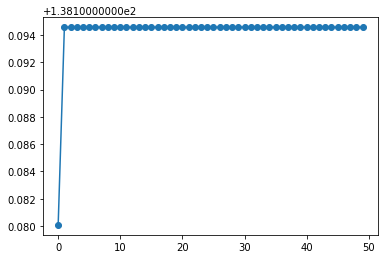

In [23]:
epochs = range(0, int(50))
plt.plot(epochs, losses, label='Loss', marker='o')
plt.show()

In [24]:
prediction, hidden = model(prepare(['#S']), model.init_hidden())
index2word[prediction.argmax().item()]

'narcoleptic'

In [25]:
def generate(start='#S', max_len=3):
    text = start.split()
    for w in range(max_len):
        prediction, hidden = model(prepare([text[-1]]), model.init_hidden())
        next_word = index2word[np.random.choice(list(index2word.keys()), p=np.exp(prediction.detach().numpy()[0]))]
        text.append(next_word)
        if next_word == '#E':
            break
    return text

In [26]:
print(generate("I do not ", 20))

['I', 'do', 'not', 'classmates', ';', 'especially', 'admittedly', 'Gershwin', 'Arnaz', 'be', 'wrong', 'certain', 'pages', 'films.', 'extremely', 'TOO', 'America', 'waste', 'going', 'home', 'indeed', 'death', 'standard']
